In [ ]:
from google.colab import files     #loading data from kaggle to colab drive
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

!kaggle datasets download -d dansbecker/cityscapes-image-pairs

import zipfile
!unzip /content/cityscapes-image-pairs.zip

Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2768.jpg  
  inflating: citysca

In [ ]:
from tqdm import tqdm      
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
###########
from keras.models import Model    
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose,BatchNormalization,MaxPooling2D,UpSampling2D,concatenate
from keras.applications.vgg16 import VGG16

In [ ]:
num_of_classes=12       #constants
Width=128
Height=128

100%|██████████| 500/500 [00:01<00:00, 305.27it/s]


(2975, 128, 128, 3)
(2975, 128, 128, 3)
[0.37058827 0.44901967 0.35882354]


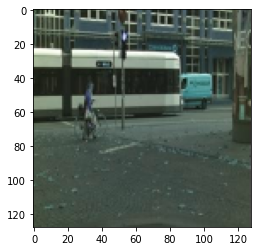

In [ ]:

def read_data(path):
    imgs=[]    #holds the first half of composite image which is the original image
    ground_truth_arr=[]   #holds the second half of composite image which is the labeled image

    
    for img in tqdm(os.listdir(path)):  ## looping on the images 
        
        img_path=os.path.join(path,img)
        img=cv2.imread(img_path)   
        Normalized_image=cv2.normalize(img,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)   #normalizing image using minmax method
        #Normalized_image=img
    
        skyscape_img=Normalized_image[:,:256]  #taking the first half of the composite image
        ground_truth=Normalized_image[:,256:]  #taking the second half of the composite image
        skyscape_img=cv2.resize(skyscape_img,(Width,Height))  # resizing image to shape(128*128)
        ground_truth=cv2.resize(ground_truth,(Width,Height))
        imgs.append(skyscape_img)

        ground_truth_arr.append(ground_truth)
    
    return imgs,ground_truth_arr

train_path='/content/cityscapes_data/train'
val_path='/content/cityscapes_data/val'


Train_imgs,Train_groundtruth=read_data(train_path)  #Train_imgs contains original images in training set ,Train_groundtruth contains annotation images in training set 
Val_imgs,val_groundtruth=read_data(val_path)     # the same for Val_imgs and val_groundtruth but for validation set
  


print(np.shape(Train_imgs))
print(np.shape(Train_groundtruth))
img1=Train_imgs[0]
print(img1[0][0])
plt.imshow(Train_imgs[0])

In [ ]:

def dist(pixel_color,colors_arr):  # return the index which has a min value of eculidian distance
  min_dst=100000.0                 # between each pixel rgb value and each rgb color in colors array 
  min_index=100000.0
  pixel_color=np.array(pixel_color)
  for i in range(0,len(colors_arr)):   #iterating on all colors in colors_arr
    color=np.array(colors_arr[i])      
    dst=np.linalg.norm(pixel_color-color)  #applying eculidian distance between pixel color and each color in 
    if dst<min_dst:                        #colors_arr and save the min distance between them in min_dst and the index
      min_dst=dst                          # in min_index
      min_index=i
  return min_index

def one_hot_encoding(ind):    #returns array of zeros at all indicies and value one only at the given index
    encoded_arr=[0]*num_of_classes
    encoded_arr[ind]=1
    return encoded_arr




"""
this color array is generated by applying kmeans to the annotation images with different number of clusters
these colors values in the color array represents the most frequent colors over all annotation images
after many experiments I got these colors to represent classes in each image
I applied Kmeans algorithm to the annotation images in a seperate python file as the colab ram crashes 
when adding kmeans code in this notebook due to colab limited ram size
"""
colors_arr=[[0,0,0],[0.5,0.25,0.5],[0.6,1,0.6],[0.3,0.3,0.3],   
            [0.6,0.6,0.6],[0.55,0,0],[0.14,0.55,0.42],[0,0,0.55],
            [0.8,0.2,0.8],[0.27,0.5,0.7],[0.88,0.1,0.24],[0.95,0.95,0]]

def convert_coloredimg_tocategorical(groundtruth_arr):  #converts the annotations rgb images into an  categorical annotations of depth 12
  categorical_label_arr=[]

  for groundtruth_img in tqdm(groundtruth_arr):  ##looping on each annotation image 
    for i in range(0,groundtruth_img.shape[0]):
      for j in range(0,groundtruth_img.shape[1]):
        pixel_color=groundtruth_img[i,j]  ##getting each pixel color
        label_index=dist(pixel_color,colors_arr)  ## getting the index which holds the nearest color to the pixel color
        """
        categorical label array replaces each pixel color (R,G,B) with a 
        one hot encoded array of depth 12 containing only a one value
        at the index that holds the nearest color to pixel color and the rest
        of the array holds zeros
        """
        categorical_label_arr.append(one_hot_encoding(label_index)) 
  return categorical_label_arr

Train_groundtruth=np.array(Train_groundtruth) ##converting list into numpy array
val_groundtruth=np.array(val_groundtruth)


#print(np.shape(categorical_label_train))
if not os.path.exists("/content/drive/My Drive/categorical_label_train4.npy"):  #save the data if it is not saved on  drive
  categorical_label_train=convert_coloredimg_tocategorical(Train_groundtruth)
  categorical_label_val=convert_coloredimg_tocategorical(val_groundtruth)

  categorical_label_train=np.reshape(categorical_label_train,(Train_groundtruth.shape[0],Width,Height,num_of_classes))
  categorical_label_val=np.reshape(categorical_label_val,(val_groundtruth.shape[0],Width,Height,num_of_classes))

  np.save("categorical_label_train4",categorical_label_train)
  np.save("categorical_label_val4",categorical_label_val)
else:    ## otherwise load the data from drive
  categorical_label_train=np.load("/content/drive/My Drive/categorical_label_train4.npy")
  categorical_label_val=np.load("/content/drive/My Drive/categorical_label_val4.npy")


In [ ]:
inp = Input(shape=(Width, Height, 3))   # model input shape

#### encoder phase (downsampling) ######
x1 = BatchNormalization()(inp)    
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)

x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)


x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)


x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)

##### decoder phase (upsampling) ######
x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)


x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)


x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(num_of_classes, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(num_of_classes, 6, activation="softmax", padding="same")(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)   ##using adam optimizer and loss function : categorical_crossentropy
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 1179776     conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:
print(np.shape(Train_imgs))
print(np.shape(Val_imgs))
Train_imgs=np.array(Train_imgs)
Train_groundtruth=np.array(Train_groundtruth)   # converting all lists into numpy array to be able to fit in the model
Val_imgs=np.array(Val_imgs)
val_groundtruth=np.array(val_groundtruth)

#results = model.fit(Train_imgs, Train_groundtruth, validation_data=(Val_imgs,val_groundtruth), batch_size=8, epochs=3)
### fitting the data to the model
results = model.fit(Train_imgs, categorical_label_train, validation_data=(Val_imgs,categorical_label_val), batch_size=16, epochs=20)

(2975, 128, 128, 3)
(500, 128, 128, 3)
Epoch 1/20
186/186 [==============================] - 65s 351ms/step - loss: 0.5108 - accuracy: 0.8386 - val_loss: 0.6376 - val_accuracy: 0.8074
Epoch 2/20
186/186 [==============================] - 65s 351ms/step - loss: 0.5060 - accuracy: 0.8392 - val_loss: 0.6132 - val_accuracy: 0.8053
Epoch 3/20
186/186 [==============================] - 65s 350ms/step - loss: 0.4899 - accuracy: 0.8441 - val_loss: 0.6019 - val_accuracy: 0.8105
Epoch 4/20
186/186 [==============================] - 65s 350ms/step - loss: 0.4757 - accuracy: 0.8485 - val_loss: 0.5986 - val_accuracy: 0.8162
Epoch 5/20
186/186 [==============================] - 65s 350ms/step - loss: 0.4705 - accuracy: 0.8498 - val_loss: 0.6125 - val_accuracy: 0.8076
Epoch 6/20
186/186 [==============================] - 65s 350ms/step - loss: 0.4684 - accuracy: 0.8500 - val_loss: 0.6103 - val_accuracy: 0.8112
Epoch 7/20
186/186 [==============================] - 65s 350ms/step - loss: 0.4520 - accur

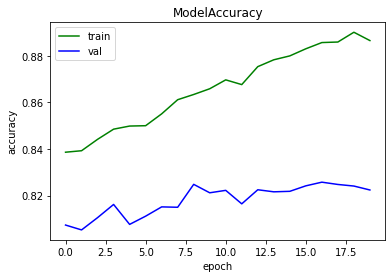

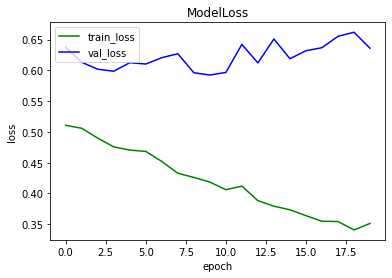

In [ ]:
     
#first plot between accuracy and val accuracy across epochs
plt.plot(results.history['accuracy'],'g')             
plt.plot(results.history['val_accuracy'],'b')   
plt.title('ModelAccuracy')  # plot t
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'],loc='upper left')
plt.show()

#second plot between loss and val loss across epochs
plt.plot(results.history['loss'],'g')
plt.plot(results.history['val_loss'],'b')
plt.title('ModelLoss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'],loc='upper left')
plt.show()

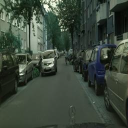

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/My Drive/cityscape.h5')
tf.keras.preprocessing.image.array_to_img(     ##original annotation image example
    Val_imgs[0]
)

(500, 128, 128, 12)


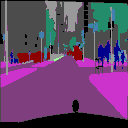

In [ ]:

categorical_to_image=[]     
print(np.shape(categorical_label_val))
categorical=categorical_label_val[0]
X,Y,C=np.shape(categorical)
for i in range(X):
  for j in range(Y):
    
    ind=np.argmax(categorical[i,j])  
   
    categorical_to_image.append(colors_arr[ind])
categorical_to_image=np.array(categorical_to_image)
categorical_to_image=np.reshape(categorical_to_image,(128,128,3))

tf.keras.preprocessing.image.array_to_img(
    categorical_to_image
)


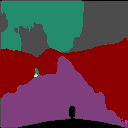

In [ ]:
import tensorflow as tf

img=np.array(Val_imgs[0].reshape(-1,128,128,3))

#tf.keras.preprocessing.image.save_img(    ##converts array into image
#    "aa.jpg",Val_imgs[10]
#)
categorical=model.predict([img])[0]  ##prediction returns 128*128*12
categorical_to_image=[]
X,Y,C=np.shape(categorical)
for i in range(X):
  for j in range(Y):
    
    ind=np.argmax(categorical[i,j])  ##getting the index of max probability
   
    categorical_to_image.append(colors_arr[ind])  ## convert categorical pixel (depth 12) to rgb pixel (depth 3)

categorical_to_image=np.array(categorical_to_image)
categorical_to_image=np.reshape(categorical_to_image,(128,128,3))

tf.keras.preprocessing.image.array_to_img(    ##converts array into image
    categorical_to_image
)




In [ ]:
model.save("/content/drive/My Drive/cityscape2.h5")

In [2]:
!pip install streamlit
!pip install pyngrok==4.1.1

     |████████████████████████████████| 7.4MB 9.2MB/s 
     |████████████████████████████████| 6.9MB 35.8MB/s 
     |████████████████████████████████| 133kB 58.8MB/s 
     |████████████████████████████████| 163kB 61.5MB/s 
     |████████████████████████████████| 4.5MB 50.6MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 112kB 54.0MB/s 
     |████████████████████████████████| 143kB 72.7MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 122kB 56.7MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=74782517a12955f994866ee979600f7c20a62243694ea635d2a342b8a66ddf6b
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for blinker: filename=blinker-1.4-cp36-none-any.whl size=13450 sha256=36173b86cfa4ba114ba7b22edfa7d7fbe45559

  Created wheel for pyngrok: filename=pyngrok-4.1.1-cp36-none-any.whl size=15971 sha256=b1f2bc415aeb3d9e0c1616011b31939871e6a993355991e70ef4824a3b528c58
  Stored in directory: /root/.cache/pip/wheels/97/71/0d/1695f7c8815c0beb3b5d9b35d6eec9243c87e6070fbe3977fa
Successfully built pyngrok


In [1]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from keras.models import load_model
import scipy.misc

colors_arr=[[0,0,0],[0.5,0.25,0.5],[0.6,1,0.6],[0.3,0.3,0.3],   
            [0.6,0.6,0.6],[0.55,0,0],[0.14,0.55,0.42],[0,0,0.55],
            [0.8,0.2,0.8],[0.27,0.5,0.7],[0.88,0.1,0.24],[0.95,0.95,0]]

st.set_option('deprecation.showfileUploaderEncoding',False)


def load_model():
  model = tf.keras.models.load_model('/content/drive/My Drive/cityscape.h5')
  return model
model =load_model()
#model.compile(optimizer='adam',loss='categorical_crossentropy')
st.write("""
      cityscape semantic segmentation
    """)

file=st.file_uploader("please upload an image",type=["jpg","png","jpeg"])

import cv2
from PIL import Image , ImageOps
import numpy as np

def import_and_predict(image_data,model):

  img=np.array(image_data)
  img=cv2.resize(img,(128,128))
  img=img.reshape(-1,128,128,3)
  img=np.array(img)


  prediction=model.predict([img])[0]
  return prediction

if file is None:
  st.text("please upload an image file")

else:
  #image=Image.open(file)
  filebytes=np.asarray(bytearray(file.read()),dtype=np.uint8)
  image=cv2.imdecode(filebytes,1)

  image=cv2.normalize(image,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F) 
  X,Y,C=np.shape(image)
  if X==256 and Y==512:
    image=image[:,:256]
  image=cv2.resize(image,(128,128))
  tf.keras.preprocessing.image.save_img(    ##converts array into image
    "aaa.jpg",image
  )

  st.image(image,use_column_width=True)
  #predictions=import_and_predict(image,model)
  #categorical=import_and_predict(image,model)
  #img=np.array(image.reshape(-1,128,128,3))
  #val=np.load('/content/val.npy')
  img=np.array(image.reshape(-1,128,128,3))
  categorical=model.predict([img])[0]  ##prediction returns 128*128*12
  categorical_to_image=[]
  X,Y,C=np.shape(categorical)
  for i in range(X):
    for j in range(Y):
      
      ind=np.argmax(categorical[i,j])  ##getting the index of max probability
    
      categorical_to_image.append(colors_arr[ind])  ## convert categorical pixel (depth 12) to rgb pixel (depth 3)

  categorical_to_image=np.array(categorical_to_image)
  categorical_to_image=np.reshape(categorical_to_image,(128,128,3))
 ##prediction returns 128*128*12
  
  st.image(categorical_to_image,use_column_width=True)

  
  st.balloons()

Writing app.py


In [2]:
!ngrok authtoken 1jp0thmxmZARcaiVTnJh8jnsWUz_2pzWUMnNXL3wuGpBb1veG

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [3]:
!nohup streamlit run app.py&

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok
public_url=ngrok.connect(port='8501')
#ssh_url=ngrok.connect(22,"tcp")
public_url

'http://a6e5ba1d27a7.ngrok.io'

In [ ]:
!pgrep streamlit

In [ ]:
ngrok.kill()

In [ ]:
!cat /content/nohup.out

2020-11-05 13:33:58.968715: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.90.235.164:8501

2020-11-05 13:34:00.767605: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-05 13:34:00.809742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-05 13:34:00.810331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-11-05 13:34:00.810377: I tensorflow/stream_executor/platform/d

In [ ]:
!ngrok http 8501

Traceback (most recent call last):
  File "/usr/lib/python3.6/subprocess.py", line 289, in call
    return p.wait(timeout=timeout)
  File "/usr/lib/python3.6/subprocess.py", line 1477, in wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.6/subprocess.py", line 1424, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 338, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 331, in run
    process.run_process(conf.DEFAULT_NGROK_PATH, args)
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/process.py", line 286, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.6/subprocess.py", line 291, in call
    p.kill()
  File "/usr/lib/pytho

In [ ]:
!ngrok http -subdomain=inconshreveable 80

#!ngrok http -hostname=cityscape.ngrok.io 80

Traceback (most recent call last):
  File "/usr/lib/python3.6/subprocess.py", line 289, in call
    return p.wait(timeout=timeout)
  File "/usr/lib/python3.6/subprocess.py", line 1477, in wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.6/subprocess.py", line 1424, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 338, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 331, in run
    process.run_process(conf.DEFAULT_NGROK_PATH, args)
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/process.py", line 286, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.6/subprocess.py", line 291, in call
    p.kill()
  File "/usr/lib/pytho

In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.0
updated 1 package in 0.902s


In [ ]:
!lt -p 8000

your url is: https://rude-elephant-9.loca.lt
^C


In [ ]:
#!lt --port     --sudo main cityscape
!ngrok http 8501 -subdomain myappp 

Traceback (most recent call last):
  File "/usr/lib/python3.6/subprocess.py", line 289, in call
    return p.wait(timeout=timeout)
  File "/usr/lib/python3.6/subprocess.py", line 1477, in wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.6/subprocess.py", line 1424, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 338, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 331, in run
    process.run_process(conf.DEFAULT_NGROK_PATH, args)
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/process.py", line 286, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.6/subprocess.py", line 291, in call
    p.kill()
KeyboardInterrupt


In [ ]:
!ngrok http -hostname=myappp.ngrok.io 80

Traceback (most recent call last):
  File "/usr/lib/python3.6/subprocess.py", line 289, in call
    return p.wait(timeout=timeout)
  File "/usr/lib/python3.6/subprocess.py", line 1477, in wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.6/subprocess.py", line 1424, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 338, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/ngrok.py", line 331, in run
    process.run_process(conf.DEFAULT_NGROK_PATH, args)
  File "/usr/local/lib/python3.6/dist-packages/pyngrok/process.py", line 286, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.6/subprocess.py", line 292, in call
    p.wait()
  File "/usr/lib/pytho

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ngrok http -hostname=cityscape.ngrok.io 8501